In [1]:
import re 

def conv(x): # 1-200 scale to 20-80
    if type(x) is str:
        x = int(x)
    r = x*60.0/200+20 # 0 -> 20, 200 -> 80
    return int(round(r/5)*5)

In [2]:
from datautil.gamelog import simplify_game_logs

def analysis(fn, rating_map):
    evntMap = {}
    for res in simplify_game_logs(fn):
        try:
            pitcher_info = rating_map[res['pitcher']]
            batter_info = rating_map[res['batter']]
        except:
            # fix: dump csv after season is done
            continue

        pitcher_hand = 'r' if pitcher_info['throws'] == 1 else 'l'

        match batter_info['bats']: #switch
            case 1:
                batter_hand = 'l'
            case 2:
                batter_hand = 'r'
            case 3: #switch
                batter_hand = 'l' if pitcher_hand == 'r' else 'r'

        key = (conv(pitcher_info['pitching_ratings_vs' + batter_hand + '_movement']), conv(batter_info['batting_ratings_vs' + pitcher_hand + '_power']))
        evnt,ab = evntMap.get(key, (0,0))
        evnt += 1 if res['result'] == "HR" else 0
        ab += 1 if res['is_ab'] else 0
        evntMap[key] = (evnt,ab)

    return [[evntMap.get((p,b),(0,0)) for b in range(20,85,5)] for p in range(20,85,5)]
            

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Example 2D list

def show_heat_map(data_raw):
    # Convert the 2D list to a numpy array
    ct = data_raw[6][6][0]/data_raw[6][6][1]*100
    data = [[t[0]/t[1]*100 - ct if t[1]>50 else 0 for t in row] for row in data_raw]
    data_array = np.array(data)

    # Create the plot
    plt.imshow(data_array, cmap='RdYlBu', vmin=-10, vmax=10)
    plt.colorbar()

    plt.xlabel('Batter Power')
    plt.ylabel('Pitcher Mov')
    plt.title('HR/AB')

    # Add labels and title
    ratings = list(range(20,85,5))
    plt.xticks(np.arange(len(ratings)), ratings)
    plt.yticks(np.arange(len(ratings)), ratings)

    for i in range(len(ratings)):
        for j in range(len(ratings)):
            if data_raw[i][j][1] > 50:
                plt.text(j, i, "{:.1f}%\n{}".format(data[i][j],data_raw[i][j][1]), ha='center', va='center', color='black', fontsize=6)

    # Display the plot
    plt.gca().invert_yaxis()
    plt.show()

In [4]:
from datautil.gamelog import load_logs
from datautil.stat_loader import load_player_rating_map

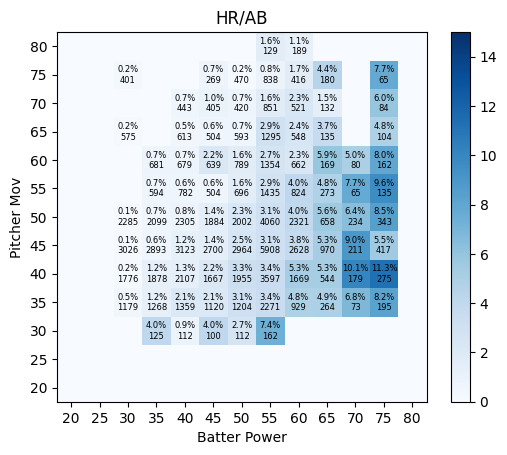

In [5]:
data1 = analysis(load_logs('test_1000'), load_player_rating_map('test_1000'))
show_heat_map(data1)

In [7]:
data_collection = []
import time
for t in range(8001, 8016):
    fn = 'test_' + str(t)
    start = time.time()
    data_collection.append(analysis(load_logs(fn), load_player_rating_map(fn)))
    end = time.time()
    print (fn, end-start)

test_8001 7.607928991317749
test_8002 8.055384397506714
test_8003 7.336974620819092
test_8004 7.619904041290283
test_8005 7.540663003921509
test_8006 7.70030665397644
test_8007 7.988706827163696
test_8008 8.129145860671997
test_8009 8.220303297042847
test_8010 7.847952365875244
test_8011 7.995917320251465
test_8012 8.162474393844604
test_8013 8.335211515426636
test_8014 26.310930728912354
test_8015 25.08648371696472


In [8]:
n = len(data_collection[0])
m = len(data_collection[0][0])

agg = [[(sum(map(lambda x: x[u][v][0], data_collection)), sum(map(lambda x: x[u][v][1], data_collection))) for v in range(m)] for u in range(n)]

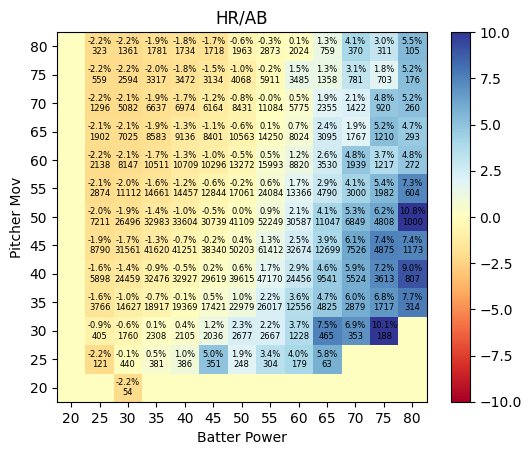

In [22]:
show_heat_map(agg)